In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import Embedding, Add

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
parent_parent_dir = os.path.dirname(parent_dir)

if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)

from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


ModuleNotFoundError: No module named 'Dtool'

In [64]:
# 读取数据
sheet = pd.read_excel('data_input/日均铁水产量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.index.freq = None
last_day = sheet['日均铁水产量'].last_valid_index()

# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
# 计算需要的31个工作日
target_days = pd.date_range(start=last_day + pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]

if len(future_data_30days) == 0:
    new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

elif future_data_30days.index.max() > target_end:
    sheet = sheet[sheet.index <= target_end]
    new_index = pd.date_range(start=last_day + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

else:
    max_future_date = future_data_30days.index.max() if len(future_data_30days) > 0 else last_day
    new_index = pd.date_range(start=max_future_date + pd.DateOffset(1), end=target_end, freq='B')
    sheet = sheet.reindex(sheet.index.union(new_index))

sheet = sheet.sort_index()

# 填充缺失值
fill_methods = {
    '日均铁水产量模拟值(预测/装置跟踪)': 'interpolate',
    '螺纹高炉利润/上海/即期': 'interpolate',
    '热卷高炉利润/上海/即期': 'interpolate',
    '247家钢铁企业盈利率':'interpolate',
    '热卷厂内/社会库存比值':'interpolate',
    '螺纹盘面利润':'interpolate',
    '铁矿钢厂库存Trend/F0.1':'interpolate',
    '铁矿基差率':'interpolate',
    '焦炭基差率':'interpolate',
    '五大钢材周度表需(预测/3年季节性/20期)':'interpolate'
} 
sheet = fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '日均铁水产量'] = sheet.loc[:last_day, '日均铁水产量'].interpolate(method='linear')

# 创建特征
sheet['螺纹高炉利润/上海/即期_提前35天'] = sheet['螺纹高炉利润/上海/即期'].shift(35)
sheet['热卷高炉利润/上海/即期_提前35天'] = sheet['热卷高炉利润/上海/即期'].shift(35)
sheet['247家钢铁企业盈利率_提前28天'] = sheet['247家钢铁企业盈利率'].shift(28)
sheet['热卷厂内/社会库存比值_提前42天'] = sheet['热卷厂内/社会库存比值'].shift(42)
sheet['螺纹盘面利润_提前56天'] = sheet['螺纹盘面利润'].shift(56)
sheet['铁矿钢厂库存Trend/F0.1_提前56天'] = sheet['铁矿钢厂库存Trend/F0.1'].shift(56)
sheet['铁矿基差率_提前28天'] = sheet['铁矿基差率'].shift(28)

sheet['热卷厂内/社会库存比值_提前42天_逆序'] = reverse_column(sheet, '热卷厂内/社会库存比值_提前42天')
sheet['铁矿基差率_提前28天_逆序'] = reverse_column(sheet, '铁矿基差率_提前28天')
sheet['铁矿钢厂库存Trend/F0.1_提前56天_逆序'] = reverse_column(sheet, '铁矿钢厂库存Trend/F0.1_提前56天')

sheet['铁矿基差率_提前28天_逆序_2024-01-01之后'] = np.where(
    sheet.index >= pd.Timestamp('2024-01-01'),
    sheet['铁矿基差率_提前28天_逆序'],
    np.nan
)

# 数据筛选
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-02-20')]
sheet_daily = sheet_daily.reset_index(drop=True)

# 删除空值
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['日均铁水产量'].notna())
]


In [65]:
# 划分数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '日均铁水产量模拟值(预测/装置跟踪)', '螺纹高炉利润/上海/即期_提前35天', 
    '热卷高炉利润/上海/即期_提前35天','247家钢铁企业盈利率_提前28天', 
    '热卷厂内/社会库存比值_提前42天_逆序', '螺纹盘面利润_提前56天', 
    '铁矿钢厂库存Trend/F0.1_提前56天_逆序', '铁矿基差率_提前28天_逆序_2024-01-01之后'
]

predict_column = '日均铁水产量'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

In [66]:


class R2Score(Metric):
    def __init__(self, name='r2', **kwargs):
        super(R2Score, self).__init__(name=name, **kwargs)
        self.ssr = self.add_weight(name='ssr', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        ssr = K.sum(K.square(y_true - y_pred))
        sst = K.sum(K.square(y_true - K.mean(y_true)))
        self.ssr.assign_add(ssr)
        self.sst.assign_add(sst)

    def result(self):
        return 1 - (self.ssr / (self.sst + K.epsilon()))

    def reset_states(self):
        self.ssr.assign(0.0)
        self.sst.assign(0.0)
def rmse_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [67]:


# 自定义 Attention Layer：每个 head 关注不同部分
def multi_feature_attention(inputs):
    # 拆分输入特征 [batch, timestep, features]
    tech_feat = inputs[:, :, :4]   # 基本面
    sent_feat = inputs[:, :, 4:7]  # 情绪面
    macro_feat = inputs[:, :, 7:]  # 宏观面

    # 分别定义各自 head，注意 head 数可调
    tech_attn = MultiHeadAttention(num_heads=2, key_dim=4, dropout=0.1)(tech_feat, tech_feat)
    sent_attn = MultiHeadAttention(num_heads=1, key_dim=3, dropout=0.1)(sent_feat, sent_feat)
    macro_attn = MultiHeadAttention(num_heads=1, key_dim=1, dropout=0.1)(macro_feat, macro_feat)

    # 融合所有 head 的输出
    merged = Concatenate(axis=-1)([tech_attn, sent_attn, macro_attn])
    return merged

# 定义 Transformer 模型
def build_multihead_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # 多视角 Attention
    attn_output = multi_feature_attention(inputs)

    # 假设最大时间步 maxlen = 1
    position_input = Input(shape=(1,), dtype='int32')
    pos_embed = Embedding(input_dim=10, output_dim=8)(position_input)
    # 残差 + LN
    attn_output = Dropout(0.2)(attn_output)
    attn_output = LayerNormalization()(attn_output)
    attn_output = Add()([attn_output, pos_embed])

    # Pooling + Dense
    pooled = GlobalAveragePooling1D()(attn_output)
    x = Dense(128, activation='relu')(pooled)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)


    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam, loss=rmse_loss, metrics=[R2Score()])
    return model

# reshape 数据
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_future_reshaped= X_future_scaled.reshape((X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

# 创建并训练模型
transformer_model = build_multihead_transformer_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

early_stopping = EarlyStopping(monitor='val_r2', mode='max', patience=100, restore_best_weights=True)

transformer_history = transformer_model.fit(
    X_train_reshaped, y_train,
    epochs=10000, batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping]
)

# 预测
y_train_pred  = transformer_model.predict(X_train_reshaped)
y_test_pred   = transformer_model.predict(X_test_reshaped)
y_future_pred = transformer_model.predict(X_future_reshaped)


train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"测试集  MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

# 存储预测
test_data['预测值']   = y_test_pred.flatten()
future_data['预测值'] = y_future_pred.flatten()


ValueError: Could not interpret optimizer identifier: <class 'keras.src.optimizers.adam.Adam'>

In [4]:
# 创建 Transformer 模型
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [5]:
# 重塑输入数据为Transformer需要的格式 (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_future_reshaped = X_future_scaled.reshape((X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

# 创建并训练 Transformer 模型
transformer_model = build_transformer_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# 早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

transformer_history = transformer_model.fit(X_train_reshaped, y_train, epochs=10000, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# 预测训练集、测试集和未来数据
y_train_pred = transformer_model.predict(X_train_reshaped)
y_test_pred = transformer_model.predict(X_test_reshaped)
y_future_pred = transformer_model.predict(X_future_reshaped)

# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse}, 训练集 R²: {train_r2}")
print(f"测试集 MSE: {test_mse}, 测试集 R²: {test_r2}")

# 存储预测结果
test_data['预测值'] = y_test_pred
future_data['预测值'] = y_future_pred

Epoch 1/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 53300.1367 - val_loss: 52157.9141
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 53047.5117 - val_loss: 51932.1016
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52758.9258 - val_loss: 51698.8359
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52735.1094 - val_loss: 51472.1641
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52357.5586 - val_loss: 51210.6641
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52147.4414 - val_loss: 50937.6367
Epoch 7/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51840.7734 - val_loss: 50656.6641
Epoch 8/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51242.8984 - val_loss: 50436.3750
Epoch 9/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51407.3164 - val_loss: 49980.9492
Epoch 10/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51087.3555 - val_loss: 49668.6641
Epoch 11/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss

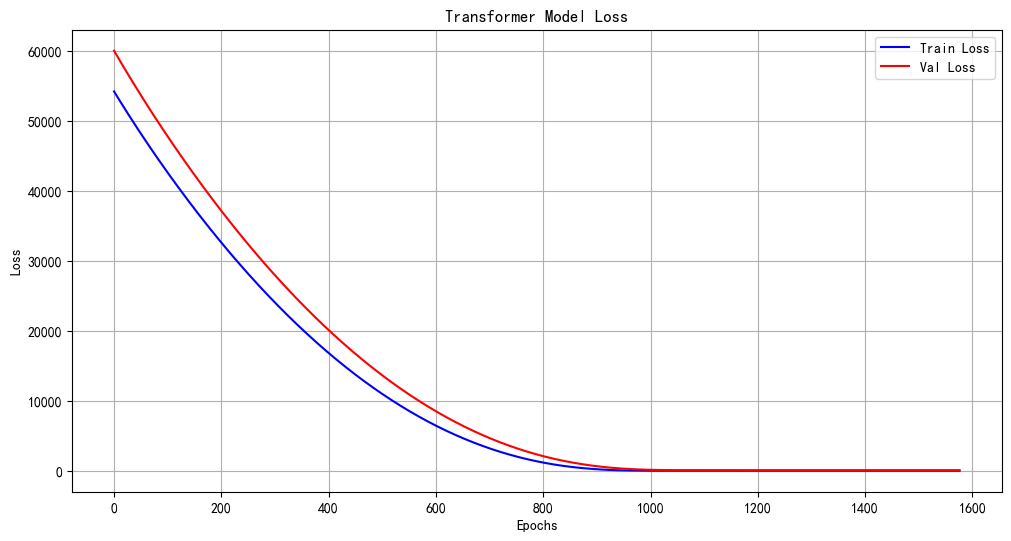

In [42]:
# 绘制train loss和val loss变化
plt.figure(figsize=(12, 6))
plt.plot(transformer_history.history['loss'], label='Train Loss', color='blue')
plt.plot(transformer_history.history['val_loss'], label='Val Loss', color='red')
plt.title('Transformer Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

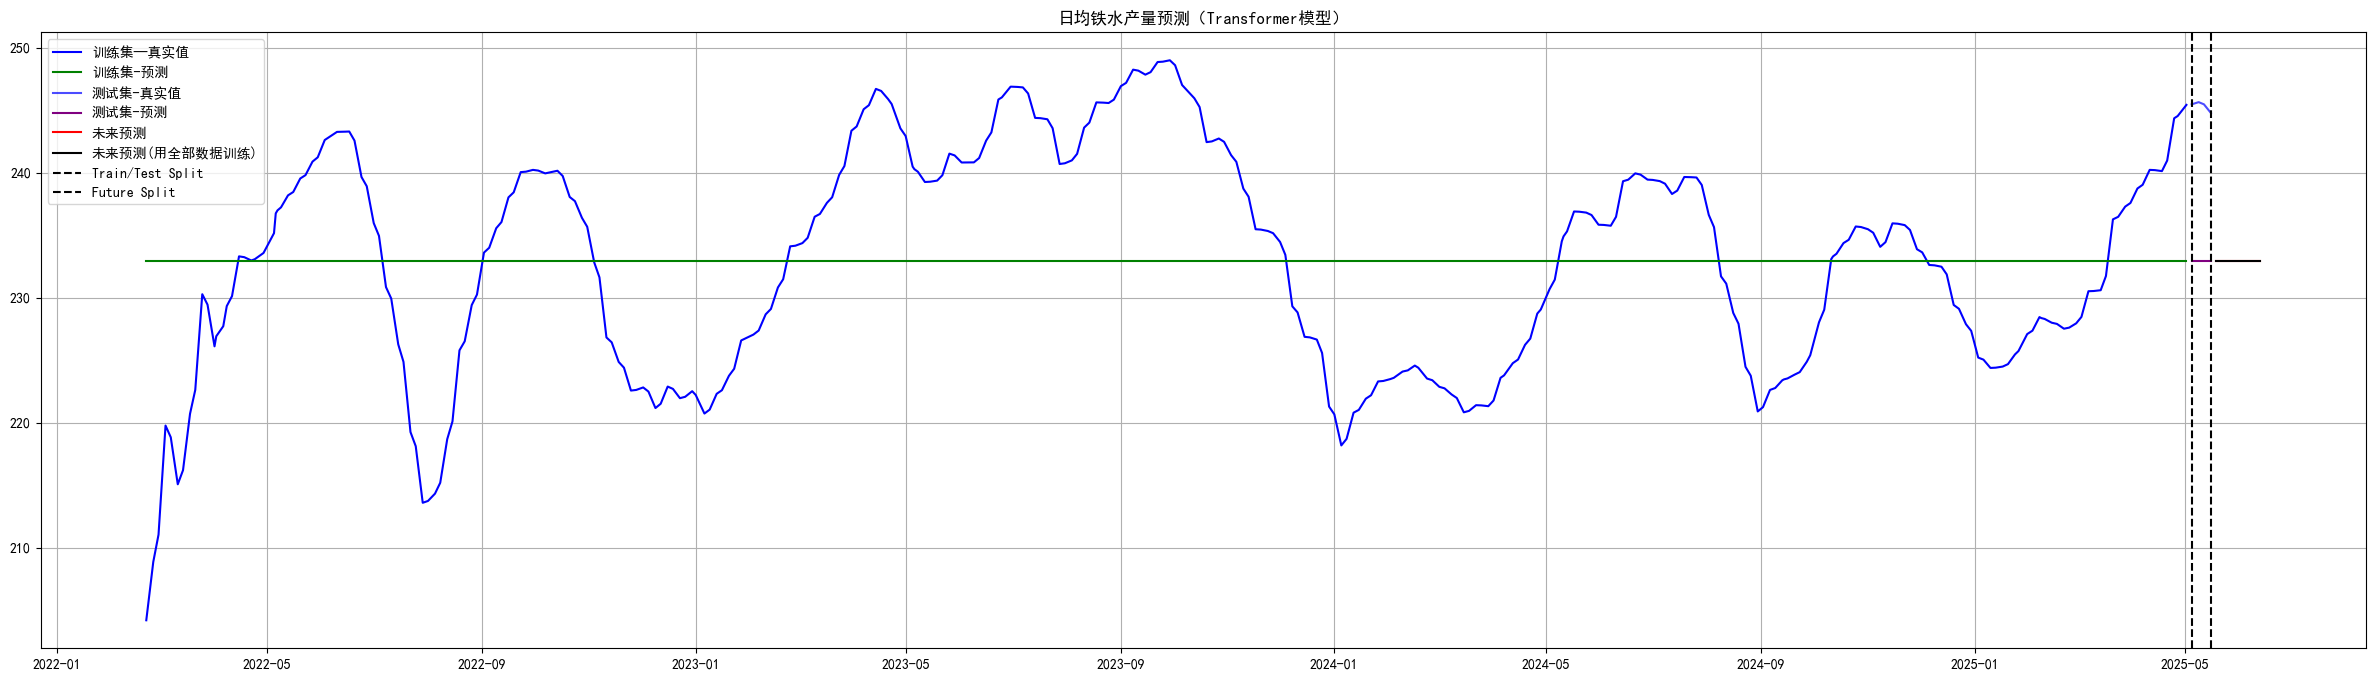

In [43]:
# 绘制预测结果
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('日均铁水产量预测（Transformer模型）')
plt.legend()
plt.grid(True)

# 展示图表
plt.show()